# Load Libraries

In [47]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
from wordcloud import WordCloud
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,auc

***Load Datasets***

In [2]:
train = pd.read_csv(r'Downloads\Datasets\IMDB\Train.csv')
valid= pd.read_csv(r'Downloads\Datasets\IMDB\Valid.csv')
test = pd.read_csv(r'Downloads\Datasets\IMDB\Test.csv')

***Train Dataset Analysis***

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    40000 non-null  object
 1   label   40000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 625.1+ KB


In [4]:
train.head(10)

,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1
5,A terrible movie as everyone has said. What ma...,0
6,Finally watched this shocking movie last night...,1
7,I caught this film on AZN on cable. It sounded...,0
8,It may be the remake of 1987 Autumn's Tale aft...,1
9,My Super Ex Girlfriend turned out to be a plea...,1


# Preprocessing

* Punctuation Removal
* Case Normalization
* Remove Stopwords
* Lemmatization


In [5]:
def Preprocessing(text):
    text = re.sub(r'[^\w\s]','',text)
    text = text.lower()
    text = [w for w in text.split(' ') if w not in stopwords.words('english')]
    text = [WordNetLemmatizer().lemmatize(token) for token in text]
    text = [WordNetLemmatizer().lemmatize(token,pos='v') for token in text]
    text = " ".join(text)
    return text

train['text'] = train.text.apply(lambda x:Preprocessing(x))
valid['text'] = valid.text.apply(lambda x:Preprocessing(x))
test['text']= test.text.apply(lambda x:Preprocessing(x))

***Balanced Dataset***

In [6]:
train['label'].value_counts()

0    20019
1    19981
Name: label, dtype: int64

***Split Dataset***

In [22]:
train_x = train['text']
valid_x = valid['text']
test_x = test['text']
train_y = train['label']
valid_y = valid['label']
test_y = test['label']

# EDA

***Text length***

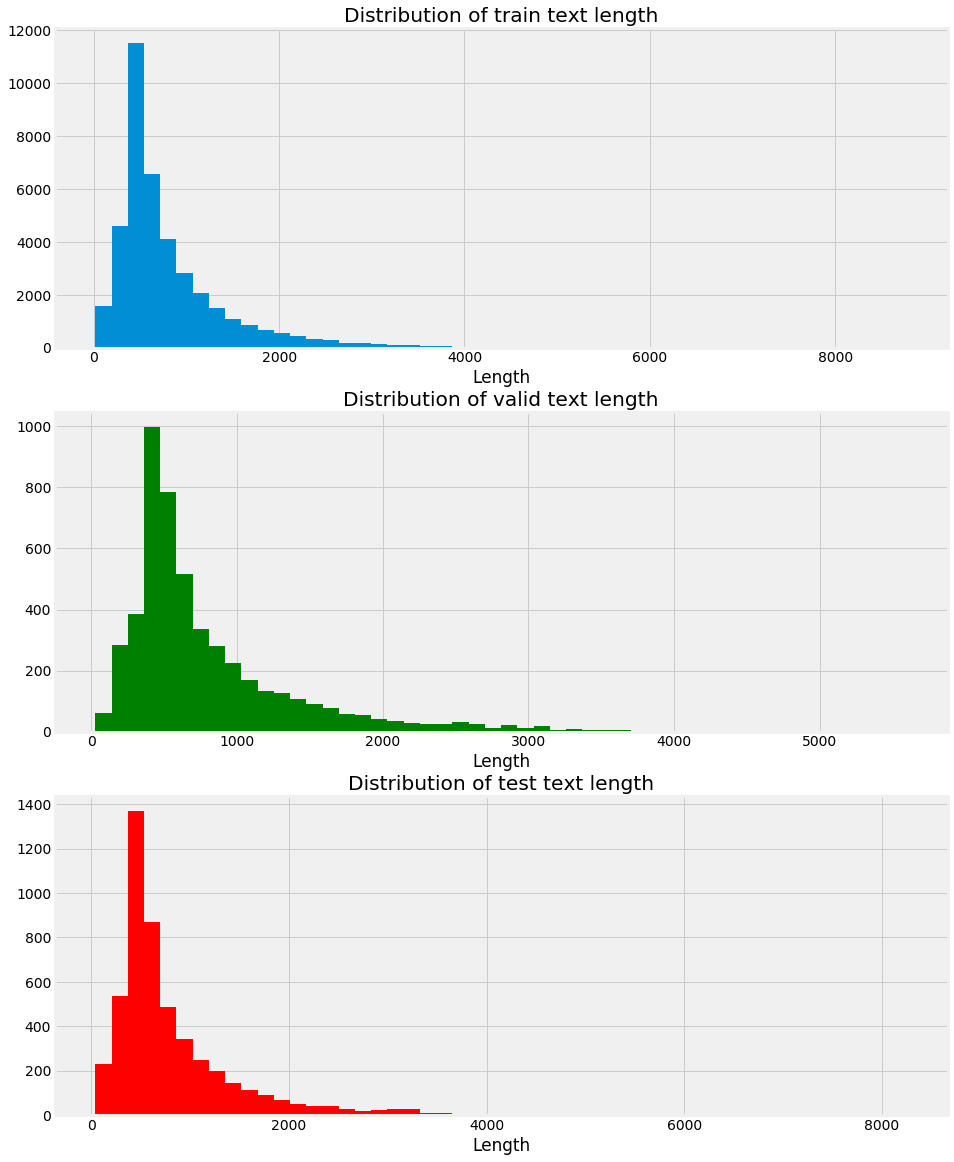

In [8]:
plt.figure(figsize=(16,20))
plt.style.use('fivethirtyeight')

plt.subplot(3,1,1)
train_len = [len(l) for l in train_x]
plt.hist(train_len,bins=50)
plt.title('Distribution of train text length')
plt.xlabel('Length')

plt.subplot(3,1,2)
valid_len = [len(l) for l in valid_x]
plt.hist(valid_len,bins=50,color='green')
plt.title('Distribution of valid text length')
plt.xlabel('Length')

plt.subplot(3,1,3)
test_len = [len(l) for l in test_x]
plt.hist(test_len,bins=50,color='red')
plt.title('Distribution of test text length')
plt.xlabel('Length')

plt.show()

***WORDCLOUD for Postive Text***

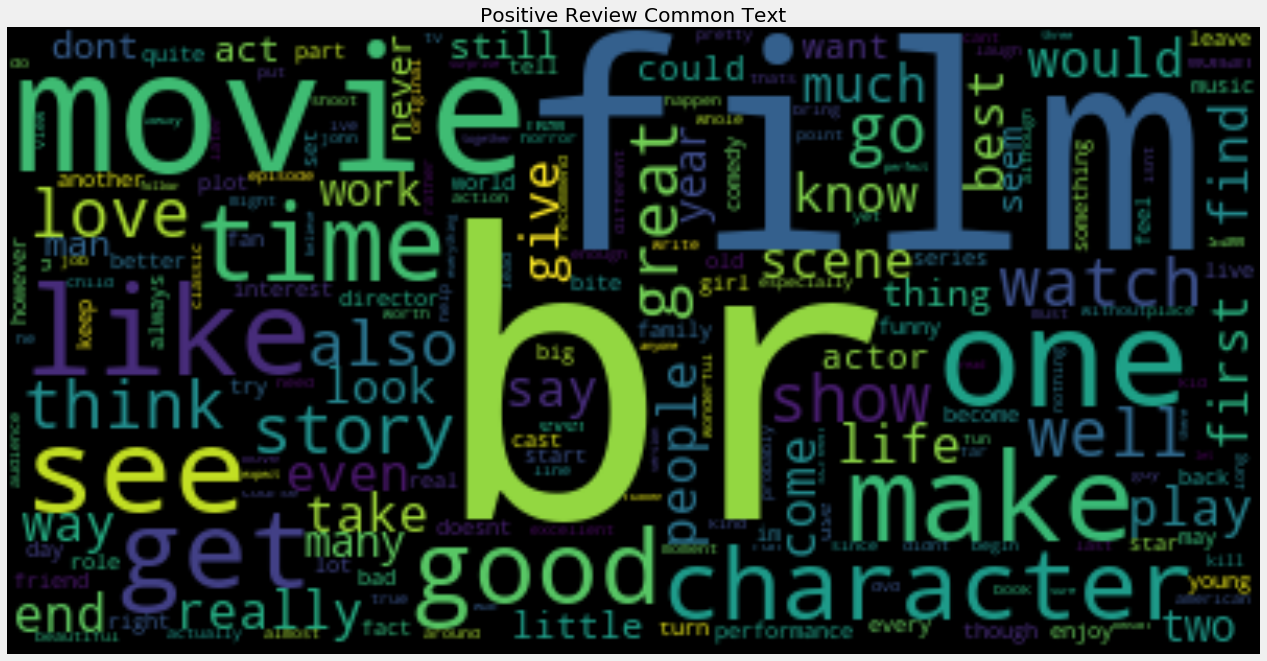

In [9]:
plt.figure(figsize=(20,20))
pos_freq = FreqDist(' '.join(train[train['label'] == 1].text).split(' '))
wc = WordCloud().generate_from_frequencies(frequencies=pos_freq)
plt.imshow(wc,interpolation='bilinear')
plt.title('Positive Review Common Text')
plt.axis('off')
plt.show()

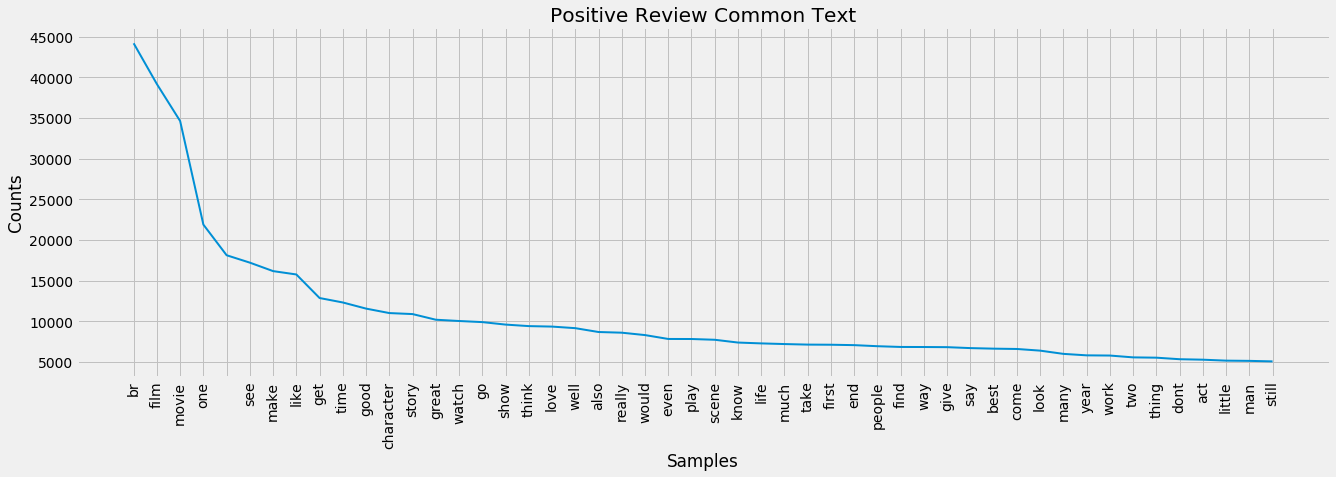

In [10]:
plt.figure(figsize=(20,6))
pos_freq.plot(50,cumulative=False,title='Positive Review Common Text')
plt.show()

***WORDCLOUD for Negative Text***

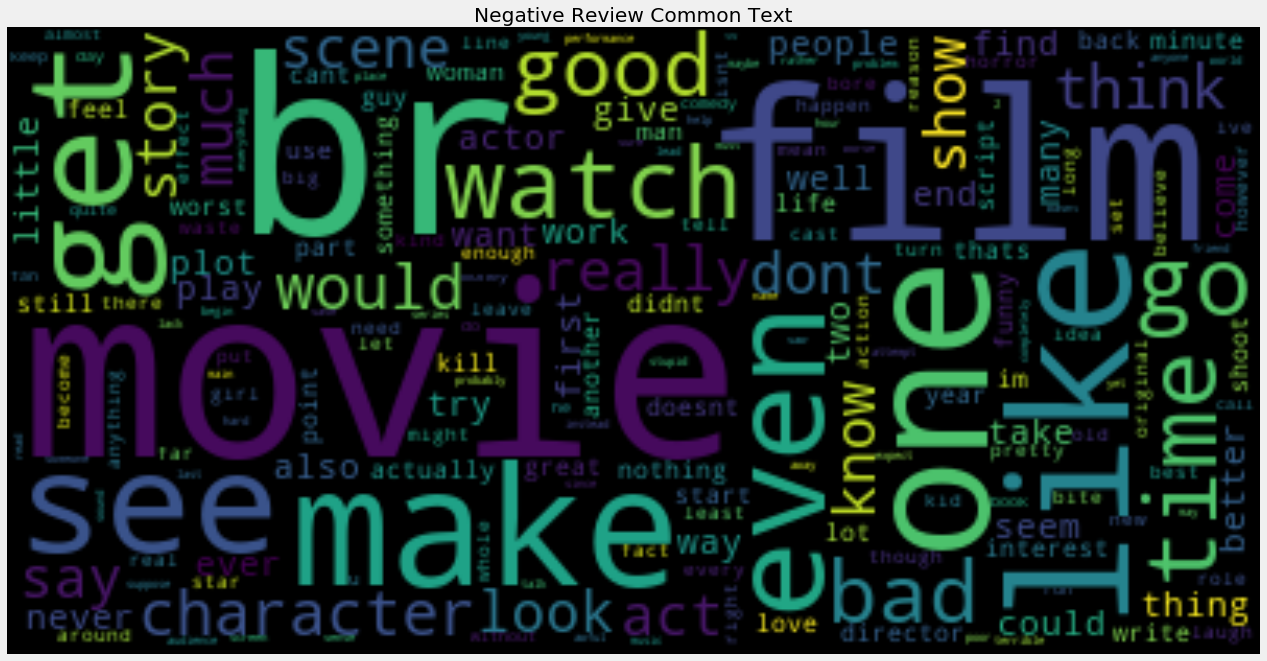

In [11]:
plt.figure(figsize=(20,20))
neg_freq = FreqDist(' '.join(train[train['label'] == 0].text).split(' '))
wc = WordCloud().generate_from_frequencies(frequencies=neg_freq)
plt.imshow(wc,interpolation='bilinear')
plt.title('Negative Review Common Text')
plt.axis('off')
plt.show()

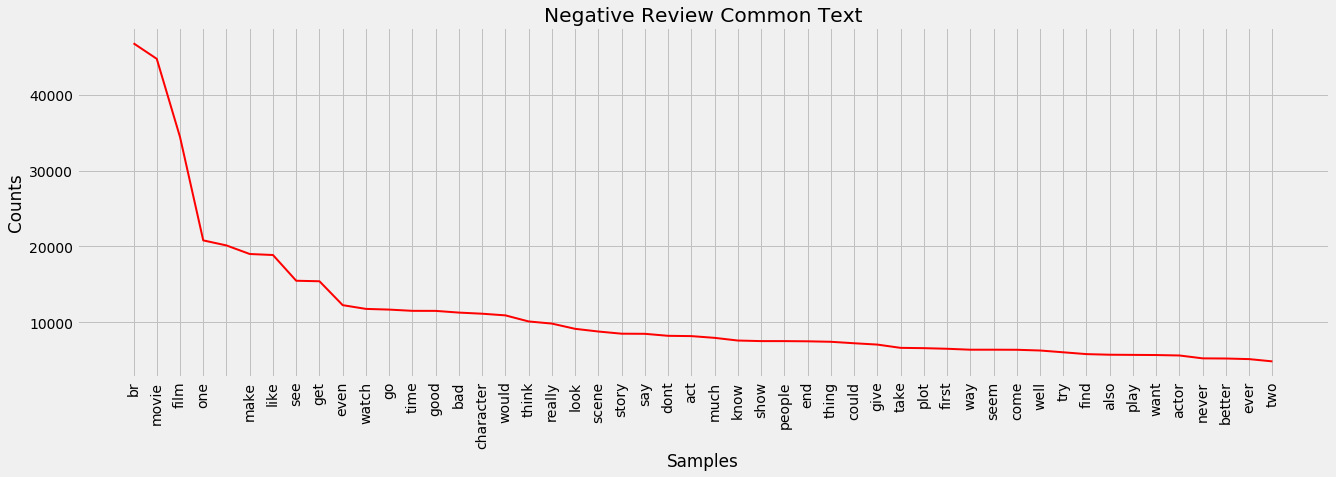

In [12]:
plt.figure(figsize=(20,6))
neg_freq.plot(50,cumulative=False,title='Negative Review Common Text',color='red')
plt.show()

# Modeling

***Preparing the Data***

In [23]:
#Tokenize the sentences
tokenizer = Tokenizer()
#preparing vocabulary
tokenizer.fit_on_texts(train_x)
#converting text into integer sequences
train_x = tokenizer.texts_to_sequences(train_x)
valid_x = tokenizer.texts_to_sequences(valid_x)
test_x = tokenizer.texts_to_sequences(test_x)
#padding to prepare sequences of same length
train_x=pad_sequences(train_x,maxlen=150)
valid_x=pad_sequences(valid_x,maxlen=150)
test_x=pad_sequences(test_x,maxlen=150)

In [26]:
size_of_vocabulary = len(tokenizer.word_index)+1
print(size_of_vocabulary)

140631


***Defining the Architecture***

In [35]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout, Bidirectional, GlobalMaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

model = Sequential()
#embedding layer
model.add(Embedding(size_of_vocabulary,128,input_length=150))
#lstm layer
model.add(Bidirectional(LSTM(128,return_sequences=True,dropout=0.2)))
#Global Maxpooling
model.add(GlobalMaxPooling1D())
#Dense Layer
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.05))
model.add(Dense(1,activation='sigmoid'))
#Add loss function, metrics, optimizer
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
#Adding callbacks
es = EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=3)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', save_best_only=True,verbose=1)
#summary
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 150, 128)          18000768  
_________________________________________________________________
bidirectional_2 (Bidirection (None, 150, 256)          263168    
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                16448     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 18,280,449
Trainable params: 18,280,449
Non-trainable params: 0
__________________________________________

In [36]:
history = model.fit(train_x,train_y,batch_size=128,epochs=5,
                    validation_data=(valid_x,valid_y),verbose=1,callbacks=[es,mc])


Epoch 1/5
313/313 [==============================] - 322s 1s/step - loss: 0.5344 - accuracy: 0.7128 - val_loss: 0.2792 - val_accuracy: 0.8812

Epoch 00001: val_accuracy improved from -inf to 0.88120, saving model to best_model.h5
Epoch 2/5
313/313 [==============================] - 315s 1s/step - loss: 0.1703 - accuracy: 0.9367 - val_loss: 0.2783 - val_accuracy: 0.8934

Epoch 00002: val_accuracy improved from 0.88120 to 0.89340, saving model to best_model.h5
Epoch 3/5
313/313 [==============================] - 340s 1s/step - loss: 0.0731 - accuracy: 0.9768 - val_loss: 0.3607 - val_accuracy: 0.8798

Epoch 00003: val_accuracy did not improve from 0.89340
Epoch 4/5
313/313 [==============================] - 341s 1s/step - loss: 0.0348 - accuracy: 0.9899 - val_loss: 0.4262 - val_accuracy: 0.8740

Epoch 00004: val_accuracy did not improve from 0.89340
Epoch 5/5
313/313 [==============================] - 341s 1s/step - loss: 0.0200 - accuracy: 0.9934 - val_loss: 0.4942 - val_accuracy: 0.8730

## Evaluating the performance of the model

***Accuracy***

In [41]:
#loading best model
model = load_model('best_model.h5')
# evaluate
loss,acc = model.evaluate(test_x,test_y)
print('Test Accuracy: {}%'.format(acc*100))

157/157 [==============================] - 7s 41ms/step - loss: 0.2723 - accuracy: 0.8946
Test Accuracy: 89.4599974155426%


***Confusion Metrics***

In [45]:
#perdict test
ypred = model.predict_classes(test_x)
#Confusion Metrics
print(confusion_matrix(test_y,ypred))

[[2218  277]
 [ 250 2255]]


***Classification Report***

In [46]:
print(classification_report(test_y,ypred))

              precision    recall  f1-score   support

           0       0.90      0.89      0.89      2495
           1       0.89      0.90      0.90      2505

    accuracy                           0.89      5000
   macro avg       0.89      0.89      0.89      5000
weighted avg       0.89      0.89      0.89      5000



***ROC***

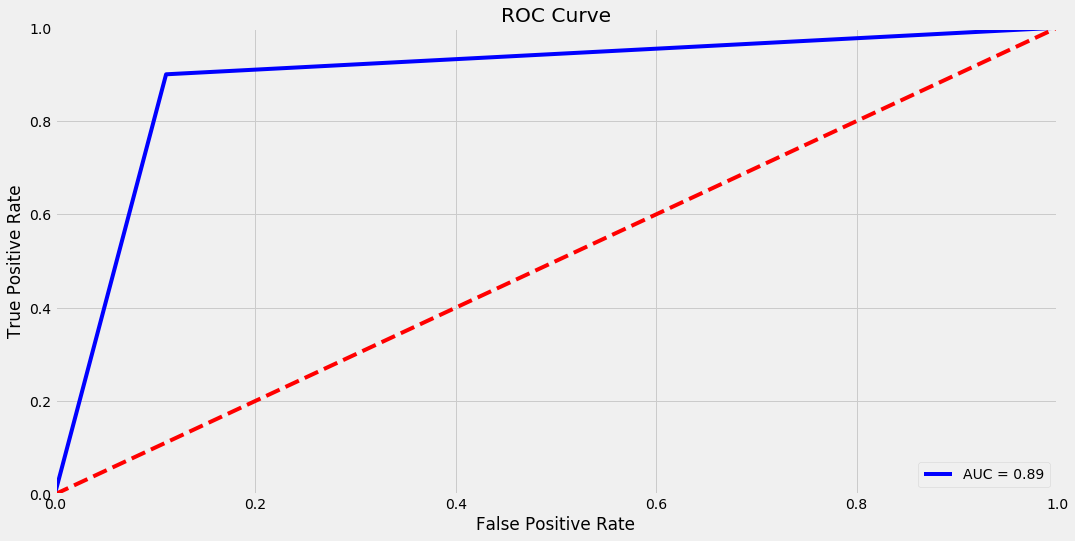

In [53]:
#plot roc
plt.figure(figsize=(16,8))
fpr,tpr,threshold = roc_curve(test_y,ypred)
roc_auc = auc(fpr, tpr)
plt.title('ROC Curve')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()